# 데이터 수집을 위한 크롤링 (유튜브 댓글 가져오기)

In [62]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
import time

In [9]:
# 웹드라이버 로드(chrome 사용)
# 웹드라이버 설치 후, 본인 경로로 수정.
driver = webdriver.Chrome("D:\python\chromedriver")

In [10]:
# 로드할 페이지 URL
driver.get('https://youtu.be/clv5xdBr7Tk')
time.sleep(1)

In [24]:
#마우스 커서 위치 지정. 스크롤링을 위해 마우스커서를 바디에 위치
body = driver.find_element_by_tag_name("body")
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

# 제목 가져오기
title = driver.find_element_by_xpath('//*[@id="container"]/h1/yt-formatted-string').text
print("Video Title: " + title + '\n\n')

Video Title: Morissette 모리셋 - Akin Ka Na Lang Vocal Review 보컬리뷰 & Reaction 리액션




In [25]:
# 전체 댓글을 수집하기 위해 스크롤바를 최하단에 위치

#페이지를 내리고 싶은 회수 지정
num_of_end = 0

while num_of_end:
    body.send_keys(Keys.END)
    time.sleep(1)
    num_of_pagedowns -= 1    

In [27]:
# 댓글 내용 (html 태그를 통해 추출)
comment = soup.find_all('yt-formatted-string', {'id':'content-text'})

comment_list = []
for c in comment:
    comment_list.append(c.get_text().strip())

# 댓글 작성자 id
user_id = soup.find_all('a', {'id':'author-text'})
id_list = []
for u in user_id:
    id_list.append(u.get_text().strip())
    
# 댓글에 좋아요 개수
like = soup.find_all('span', {'id':'vote-count-left'})

like_list_bf = []
like_list = []
for l in like:
    like_list_bf.append(l.get_text().strip())

#비워져 있는 값 0으로 대치
for bf in like_list_bf :
    if bf =='' :
        like_list.append(0)
    else :
        like_list.append(bf)

In [29]:
# 가져온 댓글 리스트 확인
for c in comment_list:
    print(c + '\n')

vocal training in the philippines?

well... we have karaoke in almost every houses..

Actually, 98% of Filipinos can sing. Unfortunately I belong in the 2%. 😂

i guess these Philippines vocal training system is one set of karaoke at everyone home..

filipinos be like: what is vocal training? 
lmao

I noticed most of the korean reactors don’t know what’s a whistle is 😂 they keep on calling it the dolphin sound

You have just heard perfection.  If you listen to too much of her singing, her voice will spoil you to the point that you will not be content listening to human singers.  Here are more, most excellent Morissette Wish bus radio performances (while she is sitting down, singing live, on a radio station, in a bus!) that are well worth reacting to (a massive understatement).  I highly recommend these Wish bus performances (because they are intimidatingly perfect!):
"Rise Up"
"Never Enough"
"Secret Love Song"
"You And I"
"Naririnig Mo Ba"
"Panaginip"
These are fantastic, flawless perfo

In [31]:
# dataframe을 만들기 위해 크기가 일정한지 확인
print(len(comment_list))
print(len(id_list))
print(len(like_list))

20
20
20


In [32]:
# csv로 저장 시 깨짐 방지를 위한 전처리(이모지-유니코드, 아랍문자 등 제거)
s_filter = re.compile("[^"
                        "a-zA-Z"      #English
                        "ㄱ-ㅣ가-힣"  #Korean
                        "0-9"         #Number
                        "\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"" #특수기호
                        "\ " #space
                        "]+")
# 댓글에 대한 전처리
comment_result = []
for i in comment_list:
    i = re.sub(s_filter,"",i)
    i = ''.join(i)
    comment_result.append(i)

In [33]:
# 아이디에 아랍문자 사용이 가능하기 때문에 아이디도 전처리 필요
id_result = []
for i in id_list:
    i = re.sub(s_filter,"",i)
    i = ''.join(i)
    id_result.append(i)

In [34]:
# 가져온 각각의 data를 하나의  dataframe으로 제작
DB = pd.DataFrame({'id' : id_result,'comment' : comment_result,'like' : like_list})

# 분석을 위해 댓글 길이 추가
DB['text_length'] = DB['comment'].apply(len)

# DB 확인
DB.head()

,id,comment,like,text_length
0,Jasmine Millet,vocal training in the philippines?well... we h...,515,82
1,Ruth Balonkita,"Actually, 98% of Filipinos can sing. Unfortuna...",274,71
2,Mohd Hafiz,i guess these Philippines vocal training syste...,224,88
3,The Duh,filipinos be like: what is vocal training? lmao,29,47
4,Jhopes Bae ph army,I noticed most of the korean reactors dont kno...,96,109


In [35]:
# csv 파일로 export
DB.to_csv("Data.set_RAW.csv",encoding="euc-kr")

# 데이터 분석

In [102]:
#학습데이터는 크롤링으로 얻은 데이터를 레이블링 한 데이터를 사용한다.

# 학습 데이터 로드, 첫 행은 헤더
SNTV_DB = pd.read_csv('data_set.csv', header=0)

# 행, 열 갯수 확인
SNTV_DB.shape

(1176, 6)

In [103]:
# 결측, 없는 데이터가 있는 행 삭제
SNTV_DB = SNTV_DB.dropna(axis=0)

# 행, 열 갯수 재확인
SNTV_DB.shape

(1169, 6)

In [43]:
# 구조 확인
SNTV_DB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1175
Data columns (total 6 columns):
id             1169 non-null object
comment        1169 non-null object
like           1169 non-null int64
text length    1169 non-null int64
evaluation     1169 non-null object
request        1169 non-null object
dtypes: int64(2), object(4)
memory usage: 63.9+ KB


In [116]:
# 자료구조 확인
SNTV_DB_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1175
Data columns (total 6 columns):
id             1169 non-null object
comment        1169 non-null object
like           1169 non-null int64
text length    1169 non-null int64
evaluation     1169 non-null int64
request        1169 non-null int64
dtypes: int64(4), object(2)
memory usage: 63.9+ KB


In [104]:
# 분석 값 설정 (X= 댓글, y=평가, z=요청)
X = SNTV_DB['comment']
y = SNTV_DB['evaluation']
z = SNTV_DB['request']

In [49]:
# 확인
X[0]

'In a Filipino\'s perspective, this kind of music is a little new to us as well. In their name SB19, SB means Sound Break which shows their advocacy of breaking the stereotypes of what the usual Filipino music is and also to show that Filipinos could also have a talent as to what Kpop Idols have. As to what they\'re also saying, they are still promoting PPop ( Filipino Pop Music) as they are using Filipino as a language for the lyrics. If you want to hear more of the power of their vocals you can try to listen and review to their debut song  "Tilaluha".'

In [50]:
# X[0]에 대한 평가 데이터
y[0]

'SS'

# 학습 전 데이터를 이용한 분석

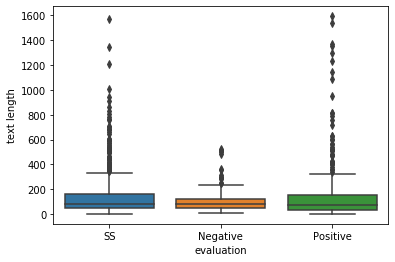

In [52]:
# 댓글 길이와 평가(긍/부정)와의 상관관계 시각화
sns.boxplot(x='evaluation', y='text length', data=SNTV_DB)

In [53]:
# 부정적 평가(0)를 하는 사람은 댓글을 길게 달지 않는다.

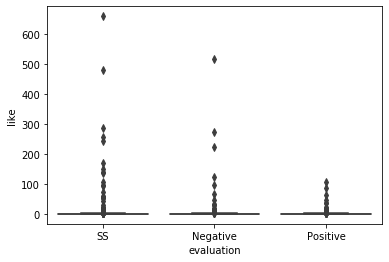

In [55]:
# 어떤 댓글이 좋아요를 많이 받는지에 대한 시각화
sns.boxplot(x='evaluation', y='like', data=SNTV_DB)

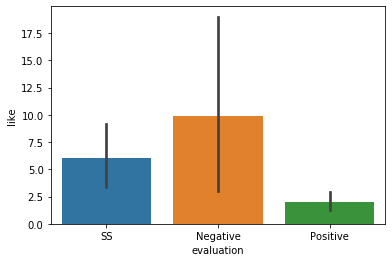

In [56]:
# 어떤 댓글이 좋아요를 많이 받는지에 대한 시각화
sns.barplot(x='evaluation', y='like', data=SNTV_DB)

In [57]:
# 사람들은 부정적인 댓글에 좋아요를 눌러 힘을 실었다.
# 하지만 부정적인 댓글의 편차는 굉장히 심하다.

In [107]:
# 데이터 전처리

# 구두점 제거, 불용어 제거
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    result = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return result

In [108]:
# 전처리 테스트
print(text_process(X[0]))

['filipinos', 'perspective', 'kind', 'music', 'little', 'new', 'us', 'well', 'name', 'sb19', 'sb', 'means', 'sound', 'break', 'shows', 'advocacy', 'breaking', 'stereotypes', 'usual', 'filipino', 'music', 'also', 'show', 'filipinos', 'could', 'also', 'talent', 'kpop', 'idols', 'theyre', 'also', 'saying', 'still', 'promoting', 'ppop', 'filipino', 'pop', 'music', 'using', 'filipino', 'language', 'lyrics', 'want', 'hear', 'power', 'vocals', 'try', 'listen', 'review', 'debut', 'song', 'tilaluha']


In [109]:
# 문서 벡터화 sklearn의 CountVectorizer로 댓글에 대한 bow 생성

bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [110]:
# bow의 크기
len(bow_transformer.vocabulary_)

3939

In [68]:
# Test
test = X[0]
test

'In a Filipino\'s perspective, this kind of music is a little new to us as well. In their name SB19, SB means Sound Break which shows their advocacy of breaking the stereotypes of what the usual Filipino music is and also to show that Filipinos could also have a talent as to what Kpop Idols have. As to what they\'re also saying, they are still promoting PPop ( Filipino Pop Music) as they are using Filipino as a language for the lyrics. If you want to hear more of the power of their vocals you can try to listen and review to their debut song  "Tilaluha".'

In [69]:
# test 데이터를 bow로 변환
bow_test = bow_transformer.transform([test])
print(bow_test)

  (0, 95)	1
  (0, 140)	3
  (0, 400)	1
  (0, 401)	1
  (0, 648)	1
  (0, 732)	1
  (0, 998)	3
  (0, 1005)	2
  (0, 1221)	1
  (0, 1367)	1
  (0, 1553)	1
  (0, 1580)	1
  (0, 1620)	1
  (0, 1664)	1
  (0, 1673)	1
  (0, 1721)	1
  (0, 1771)	1
  (0, 1887)	3
  (0, 1920)	1
  (0, 1951)	1
  (0, 2138)	1
  (0, 2238)	1
  (0, 2256)	1
  (0, 2259)	1
  (0, 2308)	1
  (0, 2467)	1
  (0, 2537)	1
  (0, 2540)	1
  (0, 2541)	1
  (0, 2626)	1
  (0, 2636)	1
  (0, 2713)	1
  (0, 2741)	1
  (0, 2800)	1
  (0, 2802)	1
  (0, 2926)	1
  (0, 3006)	1
  (0, 3037)	1
  (0, 3117)	1
  (0, 3169)	1
  (0, 3177)	1
  (0, 3180)	1
  (0, 3252)	1
  (0, 3271)	1
  (0, 3293)	1


In [74]:
# test 댓글에서 빈번하게 발생하는 단어 확인
print(bow_transformer.get_feature_names()[140])
print(bow_transformer.get_feature_names()[998])
print(bow_transformer.get_feature_names()[1887])

also
filipino
music


In [111]:
# X 전체를 bow로 변경
X = bow_transformer.transform(X)

In [112]:
# X 확인
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# 0이 아닌 값의 비율
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (1169, 3939)
Amount of Non-Zero occurrences:  15437
Density: 0.33524507942009574


In [76]:
#댓글과 평가(긍/부정) 학습 모델 구축
# training data, test data 분할
from sklearn.model_selection import train_test_split
# 학습 데이터, 테스트 데이터의 비율 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
from sklearn.naive_bayes import MultinomialNB
# naive bayes 분석을 위한 준비
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [78]:
# 테스트 데이터 예측
preds = nb.predict(X_test)

In [79]:
from sklearn.metrics import confusion_matrix, classification_report

# 테스트 데이터 예측 결과 확인 
# 평가 척도는 3개 (긍정/보통/부정)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 21   3   9]
 [  4  43  25]
 [  8  19 102]]


              precision    recall  f1-score   support

    Negative       0.64      0.64      0.64        33
    Positive       0.66      0.60      0.63        72
          SS       0.75      0.79      0.77       129

   micro avg       0.71      0.71      0.71       234
   macro avg       0.68      0.67      0.68       234
weighted avg       0.71      0.71      0.71       234



In [83]:
# 개별 댓글 분석 (긍정 댓글)
test = "자세한 리뷰 너무 좋았어요 앞으로도 좋은 리뷰 기대할게요"

In [84]:
test_transformed = bow_transformer.transform([test])
nb.predict(test_transformed)[0]

'Positive'

In [113]:
#댓글과 요청(request) 학습 모델 구축
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

In [114]:
nb = MultinomialNB()
nb.fit(X_train, z_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [115]:
preds = nb.predict(X_test)

In [116]:
print(confusion_matrix(z_test, preds))
print('\n')
print(classification_report(z_test, preds))

[[103  32]
 [  6  93]]


              precision    recall  f1-score   support

 Not-Request       0.94      0.76      0.84       135
     Request       0.74      0.94      0.83        99

   micro avg       0.84      0.84      0.84       234
   macro avg       0.84      0.85      0.84       234
weighted avg       0.86      0.84      0.84       234



In [117]:
test = "please react the song Rise up,cover by Morissete Amon"

In [118]:
test_transformed = bow_transformer.transform([test])
nb.predict(test_transformed)[0]

'Request'

# 신규 댓글 데이터 Co-ter 분류시도

In [119]:
# 댓글 문서 테스트 로드, 첫 행은 헤더
result_set = pd.read_csv('test.csv', header=0, encoding='euc-kr')
result_set = result_set.dropna(axis=0)

result_set.head()

,id,comment,like,text length
0,javie rr,Morisette was sick during her performance here...,165,154
1,ALMI SaiburraboC,"Morissette Amon aka ""Asia's Phoenix"" from the ...",42,1889
3,Kayenne Aniraloc,Finally ive been waiting for your reaction .. ...,157,58
4,Queen Rose,His reaction was so cute when he realized that...,23,71
5,Ycii Kim,"Pls. React to KZ TANDINGAN singing ""Rolling in...",105,57


In [120]:
#댓글 추출
result = result_set['comment']

In [121]:
#댓글 전체에 대한 추측을 데이터로 DataFrame에 Predict 열 추가

p_list = []

for c in result :
    result_transformed = bow_transformer.transform([c])
    p = nb.predict(result_transformed)[0]
    p_list.append(p)

result_set['predict'] = p_list

In [122]:
#열 추가 확인
result_set['predict']

0      Not-Request
1          Request
3          Request
4      Not-Request
5          Request
6      Not-Request
7          Request
8          Request
9          Request
10         Request
11     Not-Request
12         Request
13         Request
14     Not-Request
15         Request
16     Not-Request
17         Request
18         Request
19     Not-Request
20         Request
21         Request
22     Not-Request
23     Not-Request
24     Not-Request
25     Not-Request
26         Request
27     Not-Request
28     Not-Request
29         Request
30         Request
          ...     
396    Not-Request
397        Request
398    Not-Request
399    Not-Request
400        Request
401        Request
402    Not-Request
403    Not-Request
404    Not-Request
405    Not-Request
406        Request
407        Request
408    Not-Request
409    Not-Request
410        Request
411    Not-Request
412    Not-Request
413        Request
414    Not-Request
415    Not-Request
416    Not-Request
417    Not-R

In [125]:
#댓글과 예측 데이터 함께 출력
print(result_set[["comment","predict"]])

                                               comment      predict
0    Morisette was sick during her performance here...  Not-Request
1    Morissette Amon aka "Asia's Phoenix" from the ...      Request
3    Finally ive been waiting for your reaction .. ...      Request
4    His reaction was so cute when he realized that...  Not-Request
5    Pls. React to KZ TANDINGAN singing "Rolling in...      Request
6           She's still sick when she performed this..  Not-Request
7    Please react next to her first Asia's Song Fes...      Request
8    Hello oppa,,please react to Kris Lawrence"eyes...      Request
9    She is just the best and not one of the best. ...      Request
10   Is it u Pujong and just change it Something Ne...      Request
11   I feel bad when he learns what his name mean i...  Not-Request
12   That "Morissette please call me..salamat po..A...      Request
13   She sang (hangeul(?)) Korean language because ...      Request
14   LOL I WAS JUST WATCHING UR PREVIOUS REVIEW 

In [126]:
# 목표 달성 확인
result_set.head()

,id,comment,like,text length,predict
0,javie rr,Morisette was sick during her performance here...,165,154,Not-Request
1,ALMI SaiburraboC,"Morissette Amon aka ""Asia's Phoenix"" from the ...",42,1889,Request
3,Kayenne Aniraloc,Finally ive been waiting for your reaction .. ...,157,58,Request
4,Queen Rose,His reaction was so cute when he realized that...,23,71,Not-Request
5,Ycii Kim,"Pls. React to KZ TANDINGAN singing ""Rolling in...",105,57,Request
